Transfer Learning with Torchbearer
=======================================

From scratch training of deep learning models is often a long and arduous process, especially if performed on massive datasets such as ImageNet. As such, it is often prefered to start with a pretrained model and fine-tune it to the required task. This usually results in very competitive models and requires only a fraction of the time required to train from scratch. In this tutorial we shall look at how we can transfer learn an ImageNet model onto the STL10 dataset from torchvision. 

STL10 is a dataset designed for testing unsupervised semi-supervised feature learning, so has comparatively few labels to the dataset size. We use it to demonstrate one application of transfer learning, classifying without large amounts of data. Torchvision also lets us download the dataset automatically, simplifying the example. 

Note: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

Runtime   →   Change runtime type   →   Hardware Accelerator: GPU

Install Torchbearer
----------------------------------------------------------
First we install torchbearer if needed.

In [1]:
#%%
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
    # If problems arise, try
    # pip install git+https://github.com/pytorchbearer/torchbearer
    # import torchbearer
    
print(torchbearer.__version__)

0.3.2


Model and Data
---------------------------------------------

Let us first load an ImageNet pretrained model from the torchvision modelzoo and download the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/).

ImageNet classifiers generally have a large number of learnable parameters and have large compute requirements even at inference time.
[MobileNetV2](https://arxiv.org/abs/1801.04381) is a classification model designed to be applied in mobile systems, focusing on lowering the number of parameters and reducing compute cost of training/inference. We use the MobileNet model here so that we can quickly demonstrate transfer learning without having to wait for results. 

The STL10 dataset is designed to evaluate unsupervised and semi-supervised classifiers and feature extractors. As such it has a small number of labelled examples for each class. Unfortunately, despite this we can't just download only the labelled images. 

**Warning**: Downloading the dataset might take a while on slow internet connections. 

In [2]:
from torchvision.models import mobilenet_v2
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor

model = mobilenet_v2(pretrained=True, progress=False)
train_data = STL10('./data', split='train', transform=ToTensor(), download=True)
test_data = STL10('./data', split='test', transform=ToTensor(), download=True)


# Create dataloaders from the datasets
from torch.utils.data import DataLoader
batch_size = 8 

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print('\n Number of training images: {}'.format(len(train_data)))
print('Number of test images: {}'.format(len(test_data)))

Files already downloaded and verified
Files already downloaded and verified

 Number of training images: 5000
Number of test images: 8000


Visualising the Data
---------------------------------------------

STL10 is inspired by the CIFAR10 dataset, and as such has the same classes, but at a higher resolution (96x96). Lets have a look at a couple of the images to see the kind of data we are working with. We'll print the available classes, plot a batch of images and print the associated labels.   

You can see that in comparison to CIFAR, the images are much higher quality and you can usually tell exactly which class the image is from. 


 List of all classes: 
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

 Classes of our batch: 
['deer', 'monkey', 'monkey', 'dog', 'airplane', 'truck', 'bird', 'cat']


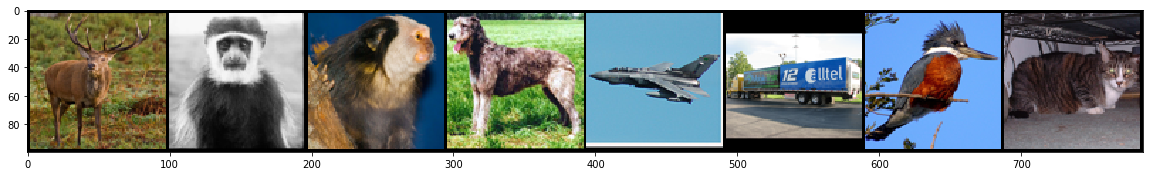

In [3]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
grid = make_grid(images)
plt.figure(figsize=(20,10))
plt.imshow(grid.permute(1,2,0))


classes = train_data.classes
print('\n List of all classes: ')
print(classes)

print('\n Classes of our batch: ')
print([classes[l] for l in labels])

Replacing the Classifier
----------------------------------------------

Now, ImageNet has 1000 classes, and as such all pretrained ImageNet models have a final layer which projects to 1000 dimensions. We have a 10 class problem in STL10, so we need to replace this layer with one that maps to 10 dimensions. To do this we just take the classifier property of our MobileNet and replace it with an equivalent to the proper number of neurons. If you decide to use a different torchvision model (we recommend you experiment with a few of them), this line will need to change depending on the torchvision implementation. See the source code for the models [here](https://github.com/pytorch/vision/tree/master/torchvision/models). 

In [0]:
import torch.nn as nn
# We copy the final layer form MobileNetV2 and replace the linear layer with one to 10 channels
model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(model.last_channel, 10),
        )

Creating the Trial
=============================

Now we want to train our MobileNet on STL10, we need to create our Torchbearer Trial. Notice that in the first trial we only pass the optimiser the parameters of the classifier. We are effectively using the MobileNet as a fixed feature extractor from which to classify.  In the second trial we do full transfer learning, where the entire model is trained. 

We recommend investigating the effect of longer training times for these models to see which is more suited to this task. 

In [5]:
from torchbearer import Trial
import torch
from torch.optim import Adam


trial = Trial(model, optimizer=Adam(model.classifier.parameters()), criterion=torch.nn.CrossEntropyLoss(reduction='sum'), metrics=['acc'])
# Whilst this is bad practice, we validate on the test set for this example for simplicity. 
# Better practice would create a separate validation split using a DatasetValidationSplitter (see quickstart example)
trial.with_train_generator(train_loader).with_val_generator(test_loader)
trial.to('cuda')
feature_extractor_hist = trial.run(5, verbose=1)

trial = Trial(model, optimizer=Adam(model.parameters()), criterion=torch.nn.CrossEntropyLoss(reduction='sum'), metrics=['acc'])
# Whilst this is bad practice, we validate on the test set for this example for simplicity. 
# Better practice would create a separate validation split using a DatasetValidationSplitter (see quickstart example)
trial.with_train_generator(train_loader).with_val_generator(test_loader)
trial.to('cuda')
transfer_learning_hist = trial.run(5, verbose=1)

Is Transfer Learning Better?
-----------------------------------------------------

We can see from the previous block that we get good accuracies very quickly with the transfer learnt models, but is this atually better than just starting from scratch? 

We now quickly train a randomly initialised model to see if fitting this model to the data is better than the ones transfered from another task. 

In [6]:
random_model = mobilenet_v2(pretrained=False, progress=False)
random_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(random_model.last_channel, 10),
        )


trial = Trial(random_model, optimizer=Adam(random_model.parameters()), criterion=torch.nn.CrossEntropyLoss(reduction='sum'), metrics=['acc'])
# Whilst this is bad practice, we validate on the test set for this example for simplicity. 
# Better practice would create a separate validation split using a DatasetValidationSplitter (see quickstart example)
trial.with_train_generator(train_loader).with_val_generator(test_loader)
trial.to('cuda')
random_model_hist = trial.run(5, verbose=1)

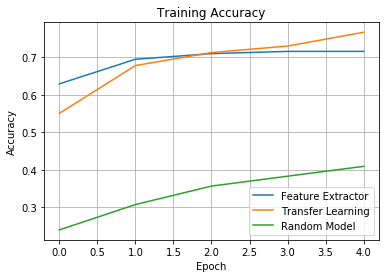

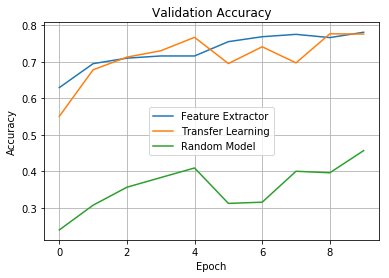

In [7]:
feature_accs = []
transfer_accs = []
random_accs = []

def plot_curves(metric_label, plot_title):
  for i in range(len(feature_extractor_hist)):
    feature_accs.append(feature_extractor_hist[i][1][metric_label])
    transfer_accs.append(transfer_learning_hist[i][1][metric_label])
    random_accs.append(random_model_hist[i][1][metric_label])

  plt.plot(feature_accs, label='Feature Extractor')
  plt.plot(transfer_accs, label='Transfer Learning')
  plt.plot(random_accs, label='Random Model')
  plt.legend()
  plt.grid()
  plt.title(plot_title)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show()

plot_curves('acc', 'Training Accuracy')
plot_curves('val_acc', 'Validation Accuracy')


We've plotted the accuracy and validation accuracy curves to compare the three different methods. 


You can see that the two pretrained models perform far better than the random model, as we were hoping. We alluded earlier to the fact that using the pretrained model as a feature extractor verses training it as a whole could lead to different results. From these particular plots, it is hard to tell which method achieves better performance so you might want to try training for longer and playing with the hyperparameters to really convince yourself which method is best for this example. Further, the random model needs much more training to be able to compare final performance to the transfer learnt models. 

Conclusion
-----------------------------
This was a very brief introduction to transfer learning with Torchbearer, showing fairly decent results when applied to a dataset that's traditionally for unsupervised models. We introduced two ways of using a pretrained network for a new task, both performing similarly, but can be useful in different situations in a real application. 

We only looked at a MobileNet model in this example, since it has few parameters and trains/evaluates quickly, however different models will show different results when transfer learnt. We encourage interested users to explore this space with the pretrained models available through torchvision. Often when fine tuning models, people lower the learning rate to avoid losing very general features learnt in pretraining. Exploring this and other hyperparameters is also an interesting extension of this exercise that we ommitted for simplicity. 